Import libraries and load data 

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate, GridSearchCV
from sklearn.metrics        import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.info()
train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15391 entries, 0 to 15390
Data columns (total 76 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   15391 non-null  int64  
 1   id                           15391 non-null  int64  
 2   short_name                   15391 non-null  object 
 3   long_name                    15391 non-null  object 
 4   player_positions             15391 non-null  object 
 5   overall                      15391 non-null  int64  
 6   potential                    15391 non-null  int64  
 7   value_eur                    15333 non-null  float64
 8   wage_eur                     15342 non-null  float64
 9   age                          15391 non-null  int64  
 10  dob                          15391 non-null  object 
 11  height_cm                    15391 non-null  int64  
 12  weight_kg                    15391 non-null  int64  
 13  club_team_id    

,Unnamed: 0,id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,club_team_id,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
count,15391.000000,15391.000000,15391.000000,15391.000000,1.533300e+04,15342.000000,15391.000000,15391.000000,15391.000000,15342.000000,...,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,15391.000000,1729.000000
mean,7695.000000,231528.535573,65.769866,71.086219,2.851328e+06,8610.310402,25.210902,181.347671,75.016698,50564.380133,...,57.898967,46.477292,47.906309,45.766097,16.478851,16.268858,16.128452,16.320772,16.586447,36.426258
std,4443.143332,27015.569028,6.890025,6.112911,7.528281e+06,18559.644411,4.753887,6.850746,7.072550,54394.414397,...,12.206433,20.243681,21.296095,20.821395,17.662887,16.924093,16.633380,17.151288,17.975868,10.748515
min,0.000000,41.000000,47.000000,49.000000,9.000000e+03,456.558174,16.000000,155.000000,51.000000,1.000000,...,12.000000,4.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,15.000000
25%,3847.500000,214610.500000,61.000000,67.000000,4.750000e+05,947.936111,21.000000,176.000000,70.000000,467.000000,...,50.000000,29.000000,28.000000,25.000000,8.000000,8.000000,8.000000,8.000000,8.000000,27.000000
50%,7695.000000,236573.000000,66.000000,71.000000,9.750000e+05,2841.616875,25.000000,181.000000,75.000000,1935.000000,...,59.000000,52.000000,55.000000,53.000000,11.000000,11.000000,11.000000,11.000000,11.000000,36.000000
75%,11542.500000,253613.000000,70.000000,75.000000,2.000000e+06,7683.740466,29.000000,186.000000,80.000000,111138.000000,...,66.000000,63.000000,65.000000,63.000000,14.000000,14.000000,14.000000,14.000000,14.000000,45.000000
max,15390.000000,264638.000000,92.000000,93.000000,1.375000e+08,331680.463188,54.000000,203.000000,110.000000,115820.000000,...,95.000000,92.000000,93.000000,92.000000,91.000000,92.000000,93.000000,92.000000,90.000000,65.000000


## EDA

We want to investigate which features missing more values and need imputation/encoding hence we build a data frame with the 20 columns that have the highest fraction of missing values.

In [106]:
# percentage of missing for every column
missing_pct = (train.isnull().sum() / len(train) * 100)

# take the 10 worst columns, turn into a DataFrame, tidy the columns
top20_missing = (
    missing_pct
    .sort_values(ascending=False)
    .head(20)                       # top-20
    .reset_index()                  # turn into 2-column DF
    .rename(columns={'index': 'column', 0: 'pct_missing'})
    .assign(pct_missing=lambda d: d['pct_missing'].round(1))  # 1-dec place
)

top20_missing.style.format({'pct_missing': '{:.1f}%'})


,column,pct_missing
0,nation_jersey_number,96.1%
1,nation_position,96.1%
2,club_loaned_from,94.3%
3,player_tags,92.5%
4,goalkeeping_speed,88.8%
5,player_traits,51.6%
6,physic,11.2%
7,defending,11.2%
8,passing,11.2%
9,shooting,11.2%


Identification of numerical and categorical variables.

In [83]:
# Manually identify the id columns to remove them from the numerical columns  
id_cols = [
    'Unnamed: 0',        
    'id',                
    'club_team_id',      
    'nationality_id'     
]

# Identify the numerical columns dropping the id features 
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(id_cols, errors='ignore')

# Identify the categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Print the numerical and categorical columns
print(f"Numerical columns ({len(numerical_cols)}):")
print(numerical_cols, '\n')
print(f"Categorical columns({len(categorical_cols)}):")
print(categorical_cols, '\n')


Numerical columns (56):
Index(['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm',
       'weight_kg', 'league_level', 'club_jersey_number',
       'club_contract_valid_until', 'nation_jersey_number', 'weak_foot',
       'skill_moves', 'international_reputation', 'release_clause_eur', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentali

We investgate the distribution of the target value value_eur through histogram and boxplot and we notice it is right skewed, therefore we log transform it.

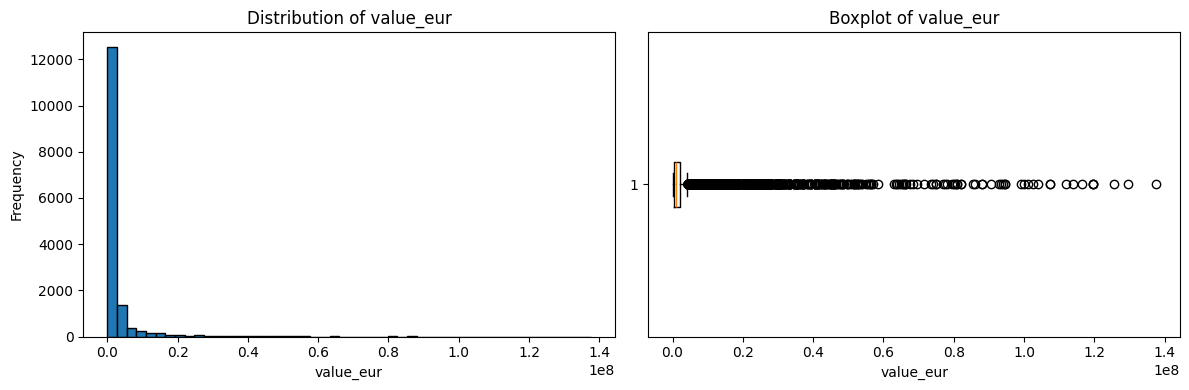

In [84]:
# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram
axes[0].hist(train['value_eur'].dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur')
axes[0].set_xlabel('value_eur')
axes[0].set_ylabel('Frequency')

# Boxplot
axes[1].boxplot(train['value_eur'].dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur')
axes[1].set_xlabel('value_eur')

plt.tight_layout()
plt.show()

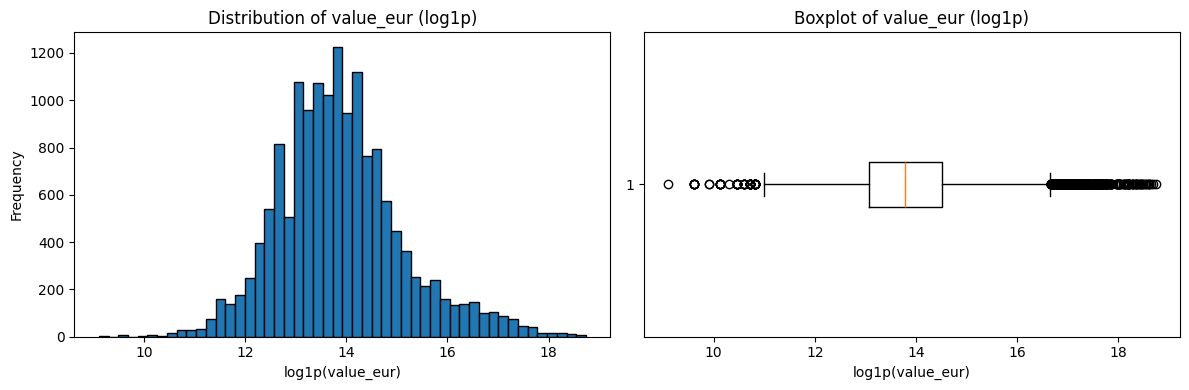

In [85]:
# Create the log-transformed target
log_target = np.log1p(train['value_eur'].clip(lower=0))

# Prepare side-by-side plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Histogram of log1p(value_eur)
axes[0].hist(log_target.dropna(), bins=50, edgecolor='black')
axes[0].set_title('Distribution of value_eur (log1p)')
axes[0].set_xlabel('log1p(value_eur)')
axes[0].set_ylabel('Frequency')

# Boxplot of log1p(value_eur)
axes[1].boxplot(log_target.dropna(), vert=False)
axes[1].set_title('Boxplot of value_eur (log1p)')
axes[1].set_xlabel('log1p(value_eur)')

plt.tight_layout()
plt.show()

Investigate the correlation among variables and selecting highly correlated pairs, then we create a list with the variables to remove, keeping the most correlated with value_eur.

In [103]:
# Build correlation matrix among numeric columns  (+ target)
corr = train.corr(numeric_only=True)

TARGET  = 'value_eur'
THRESH  = 0.70

pairs = [(c1, c2)
         for c1 in corr.columns
         for c2 in corr.columns
         if c1 != c2 and abs(corr.loc[c1, c2]) > THRESH]

cols_to_drop = set()

for c1, c2 in pairs:
    # keep the one with the **stronger** correlation to the target
    if corr.loc[c1, TARGET] > corr.loc[c2, TARGET]:
        cols_to_drop.add(c2)
    else:
        cols_to_drop.add(c1)

print(f"{len(cols_to_drop)} columns flagged:\n{cols_to_drop}")

40 columns flagged:
{'attacking_volleys', 'movement_sprint_speed', 'goalkeeping_diving', 'wage_eur', 'dribbling', 'movement_agility', 'goalkeeping_handling', 'movement_balance', 'movement_acceleration', 'skill_long_passing', 'mentality_interceptions', 'attacking_heading_accuracy', 'goalkeeping_positioning', 'power_long_shots', 'skill_fk_accuracy', 'mentality_positioning', 'passing', 'attacking_crossing', 'defending_marking_awareness', 'attacking_finishing', 'goalkeeping_kicking', 'height_cm', 'mentality_penalties', 'skill_ball_control', 'mentality_vision', 'power_strength', 'release_clause_eur', 'goalkeeping_reflexes', 'movement_reactions', 'skill_moves', 'defending_sliding_tackle', 'power_stamina', 'mentality_aggression', 'id', 'attacking_short_passing', 'mentality_composure', 'shooting', 'skill_dribbling', 'defending_standing_tackle', 'skill_curve'}


Correlation matrix, idk if keeping it,is it informative? 

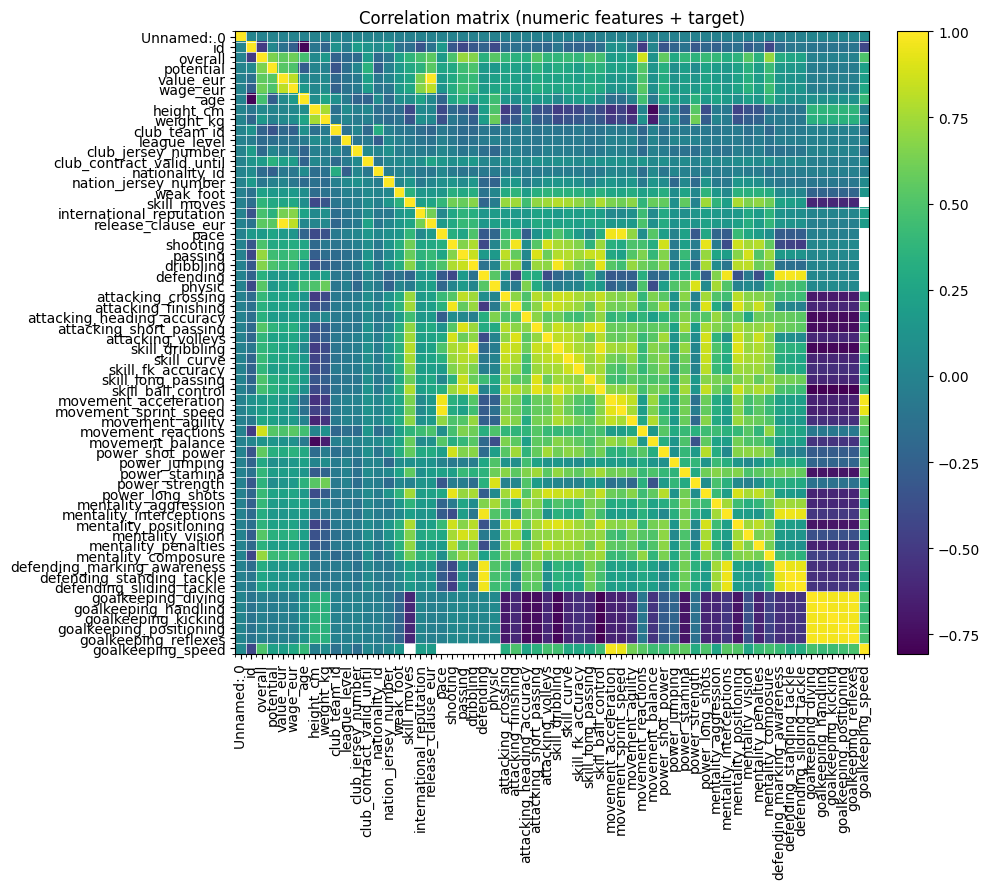

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# heat-map 
fig, ax = plt.subplots(figsize=(10,9))     

im = ax.imshow(corr.values, aspect='auto')   # default 'viridis' colormap

# axis labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)

# optional gridlines
ax.set_xticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr.columns), 1), minor=True)
ax.grid(which='minor', color='w', linewidth=.5)

# colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation matrix (numeric features + target)")

plt.tight_layout()
plt.show()


## Preprocessing 

We create a loading and cleaning function and a function that applies tome minimal pre processing to our data that we can call when applying different models.

In [88]:
def load_and_clean(filepath):
    # 1) Load and drop rows with missing target
    df = pd.read_csv(filepath)
    df = df.dropna(subset=['value_eur'])
    
    # 2a) Separate target
    y = df.pop('value_eur')
    X = df.copy()

    # 2b) Apply log transformation to the target variable since it is highly skewed
    y = np.log1p(y) 

    # 2c) Apply log transformation to the wage_eur feature since it is highly skewed
    if 'wage_eur' in X:
        X['wage_eur'] = np.log1p(X['wage_eur'])

    # 3a) Drop worst‐missing features 
    drop_missing = X.isnull().sum().nlargest(6).index
    X = X.drop(columns=drop_missing)

    # 3b) Drop irrelevant IDs and release_clause_eur which creates multicollinearity 
    drop_ids = [
        'Unnamed: 0', 'id', 'short_name', 'long_name',
        'dob', 'nationality_id', 'club_jersey_number', 'club_team_id', 'release_clause_eur'
    ]
    X = X.drop(columns=drop_ids)
    
    # 3c) Modify features in form of dates extracting the year
    X['club_joined'] = pd.to_datetime(X['club_joined'], errors='coerce')
    X['club_joined_year'] = X['club_joined'].dt.year
    X = X.drop(columns=['club_joined'])
    
    return X, y


# Define the preprocesssor
preprocessor = ColumnTransformer([
    # numeric: median‐impute + scale
    ('num',
       Pipeline([
           ('imputer', SimpleImputer(strategy='median')),
           ('scaler',   StandardScaler())
       ]),
       make_column_selector(dtype_include=np.number)
    ),
    # categorical: constant‐impute + one‐hot
    ('cat',
       Pipeline([
           ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
           ('onehot',  OneHotEncoder(handle_unknown='ignore',
                                     sparse_output=False))
       ]),
       make_column_selector(dtype_exclude=np.number)
    )
],
    remainder='drop'  # drop anything else
)

## Feature engineering 

Here we define a transformer to apply our additional feature engineering  

In [89]:
from sklearn.preprocessing import FunctionTransformer

def feat_eng(df, *, cols_to_drop = cols_to_drop):
    """
    • Drop pre-selected high-correlation columns
    • Add age_squared
    • Add is_defender / is_midfielder / is_forward / is_goalkeeper
      from player_positions, then drop player_positions
    """
    X = df.drop(columns=cols_to_drop, errors='ignore').copy()

    # age² 
    if 'age' in X:
        X['age_squared'] = X['age'] ** 2

    # role dummies (your preferred loop) 
    if 'player_positions' in X:
        role_to_group = {
            'GK':'Goalkeeper',
            'CB':'Defender','LB':'Defender','RB':'Defender',
            'LWB':'Defender','RWB':'Defender',
            'CDM':'Midfielder','CM':'Midfielder','CAM':'Midfielder',
            'LM':'Midfielder','RM':'Midfielder',
            'ST':'Forward','CF':'Forward','LW':'Forward','RW':'Forward'
        }

        X['is_defender']   = 0
        X['is_midfielder'] = 0
        X['is_forward']    = 0
        X['is_goalkeeper'] = 0

        for idx, pos in X['player_positions'].dropna().items():
            roles   = [r.strip() for r in pos.split(',')]
            groups  = {role_to_group.get(r, 'Goalkeeper') for r in roles}

            if 'Defender'   in groups: X.at[idx, 'is_defender']   = 1
            if 'Midfielder' in groups: X.at[idx, 'is_midfielder'] = 1
            if 'Forward'    in groups: X.at[idx, 'is_forward']    = 1
            if 'Goalkeeper' in groups: X.at[idx, 'is_goalkeeper'] = 1

        X = X.drop(columns=['player_positions'])

    return X

feat_eng_step = FunctionTransformer(
    feat_eng,
    validate=False,                      # keep DataFrame intact
    kw_args={'cols_to_drop': COLS_TO_DROP}   
)


## Baseline model 

We tried to model a Linear Regression on our minimally pre-processed data and obtained the following results.

In [90]:
# Load data
X, y = load_and_clean('data/train.csv')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 80 % train / 20 % test
    random_state= 18,        # reproducible split
    shuffle=True
)
# Build Linear Regression pipeline
pipeline = Pipeline([
    ('feat_eng',  feat_eng_step),
    ('preprocess', preprocessor),
    ('model',      LinearRegression())
])

# Fit on the training data
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_train_pred = pipeline.predict(X_train)
y_test_pred  = pipeline.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Back‑transform from log(1+x) to euros 
y_train_true     = np.expm1(y_train)        # original € values
y_test_true      = np.expm1(y_test)

y_train_pred_eur = np.expm1(y_train_pred)   # predicted € values
y_test_pred_eur  = np.expm1(y_test_pred)

# Metrics
train_rmse_eur = np.sqrt(mean_squared_error(y_train_true, y_train_pred_eur))
test_rmse_eur  = np.sqrt(mean_squared_error(y_test_true,  y_test_pred_eur))

train_r2_eur = r2_score(y_train_true, y_train_pred_eur)
test_r2_eur  = r2_score(y_test_true,  y_test_pred_eur)

print(f"Train RMSE (EUR): {train_rmse_eur:.0f}")
print(f"Test  RMSE (EUR): {test_rmse_eur:.0f}")
print(f"Train  R² (EUR):  {train_r2_eur:.3f}")
print(f"Test   R² (EUR):  {test_r2_eur:.3f}")


Train RMSE (EUR): 2035754
Test  RMSE (EUR): 1457539
Train  R² (EUR):  0.929
Test   R² (EUR):  0.958


## Lasso implementation
We chose Lasso specifically because it forces many of the learned coefficients βⱼ to be exactly 0. That means the model itself performs feature selection, leaving only the most predictive variables active and giving us a concise, easily interpretable list of drivers of player value. Because of this built-in sparsity, we kept our preprocessing pipeline as minimal as possible, no elaborate feature engineering beyond basic imputation and scaling, so that every nonzero coefficient directly corresponds to a raw input feature, making the final model both simple and transparent.

In [91]:
import pandas as pd
import numpy as np

from sklearn.pipeline      import Pipeline
from sklearn.compose       import ColumnTransformer, make_column_selector
from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model  import LassoCV
from sklearn.model_selection import KFold, cross_val_score

# Load data
X, y = load_and_clean("data/train.csv")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 80 % train / 20 % test
    random_state= 18,        # reproducible split
    shuffle=True
)

# α tuning with LassoCV  
alpha_search = np.logspace(-5, -3, 20)          

pipe_cv = Pipeline([
    ('prep',  preprocessor),
    ('lasso', LassoCV(alphas=alpha_search,
                      cv=5,          # internal k-fold only on X_tr
                      max_iter=10_000,
                      n_jobs=-1,
                      random_state=42))
])

pipe_cv.fit(X_train, y_train)
best_alpha = pipe_cv.named_steps['lasso'].alpha_
print(f"Best α from CV: {best_alpha:.6f}")


# Lasso fit
pipe_final = Pipeline([
    ('prep',  preprocessor),
    ('lasso', Lasso(alpha=best_alpha, max_iter=10_000))
]).fit(X_train, y_train)


# Predict on train & test → back-transform → metrics
y_tr_pred = pipe_final.predict(X_train)
y_te_pred = pipe_final.predict(X_test)

# back-transform from log(1+x) to €
y_tr_true     = np.expm1(y_train)
y_te_true     = np.expm1(y_test)
y_tr_pred_eur = np.expm1(y_tr_pred)
y_te_pred_eur = np.expm1(y_te_pred)

train_rmse_eur = np.sqrt(mean_squared_error(y_tr_true, y_tr_pred_eur))
test_rmse_eur  = np.sqrt(mean_squared_error(y_te_true, y_te_pred_eur))

train_r2_eur = r2_score(y_tr_true, y_tr_pred_eur)
test_r2_eur  = r2_score(y_te_true, y_te_pred_eur)

print(f"\nTrain RMSE (EUR): {train_rmse_eur:.0f}")
print(f"Test  RMSE (EUR): {test_rmse_eur:.0f}")
print(f"Train  R² (EUR):  {train_r2_eur:.3f}")
print(f"Test   R² (EUR):  {test_r2_eur:.3f}")


Best α from CV: 0.000070

Train RMSE (EUR): 2118461
Test  RMSE (EUR): 1647109
Train  R² (EUR):  0.923
Test   R² (EUR):  0.946
